# 簡介

**Deep Infomax(DIM)**模型主要用於，以無監督方式，分析圖片特徵。

其網絡架構，使用了AE和GAN。而損失函數，使用了MINE和f-GAN。

在此之上，又從
* 全域損失
* 局部損失
* 先驗損失

三個損失出發，對模型進行訓練。

其詳細內容，可參考: PyTorch的"DIM模型"。

In [ ]:
# 掛載雲端硬碟

from google.colab import drive
drive.mount('/content/drive')

# 實作

我們使用DIM模型，分析圖片資訊，並用分析出來的低維特徵，製作圖片搜索器。

所謂"圖片搜索器"，分為
* 圖片的特徵比對
* 圖片的特徵分析

其中，圖片的特徵分析是關鍵步驟。特徵分析也是深度學習模型中，處理資料的主要環節，也是無監督模型所研究的方向。

## 載入套件

In [1]:
import numpy as np
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.activations import *
from tensorflow.keras import optimizers

import os
import random

## 載入資料集

資料集使用MNIST。

In [2]:
# (x_train, y_train), (x_test, y_test) = mnist.load_data(path='mnist.pkl.gz')
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

11490434/11490434 [==============================] - 1s 0us/step


## 建立DIM模型

### 編碼器

通過多個卷積層，對輸入數據進行編碼，生成64維特徵向量。

In [3]:
class Encoder(tf.keras.Model):  # 分析圖片特征
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)
        self.c0 = Conv2D(64, 3, strides=1, activation=tf.nn.relu)  # 26
        self.c1 = Conv2D(128, 3, strides=1, activation=tf.nn.relu)  # 24
        self.c2 = Conv2D(256, 3, strides=1, activation=tf.nn.relu)  # 22
        self.c3 = Conv2D(512, 3, strides=1, activation=tf.nn.relu)  # 20
        self.l1 = Dense(64)  # (512*20*20, 64)

        # 定義BN層
        self.b1 = BatchNormalization()
        self.b2 = BatchNormalization()
        self.b3 = BatchNormalization()

    def call(self, x):
        x = Reshape((28, 28, 1))(x)
        h = self.c0(x)

        features = self.b1(self.c1(h))  # b 24 24 128
        h = self.b2(self.c2(features))
        h = self.b3(self.c3(h))

        h = Flatten()(h)
        encoded = self.l1(h)  # b 64
        return encoded, features

### 判別器

實現局部、全部、先驗判別器的結構，並合併每個判別器的損失函數。

我們會對互信息執行取反操作，將最大化問題變成最小化問題，在訓練過程中，可以使用最小化損失的方法，進行處理。

因為判別器的目標是，將真實數據和生成數據的分布差異最大化，所以，也需要取反，通過最小化損失的方法來實現。

在訓練過程中，梯度可以通過損失函數，直接傳播到編碼器，進行聯合優化，所以不需要對編碼器額外進行損失函數的定義。

In [4]:
class DeepInfoMaxLoss(tf.keras.Model):
    def __init__(self, alpha=0.5, beta=1.0, gamma=0.1, **kwargs):
        super(DeepInfoMaxLoss, self).__init__(**kwargs)
        # 初始化損失的加權參數
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

        # 定義編碼器
        self.encoder = Encoder()
        # 定義局部判別器
        self.local_d = Sequential([
            Conv2D(512, 1, strides=1, activation=tf.nn.relu),
            Conv2D(512, 1, strides=1, activation=tf.nn.relu),
            Conv2D(1, 1, strides=1)
        ])
        # 定義先驗判別器
        self.prior_d = Sequential([
            Dense(1000, batch_input_shape=(None, 64), activation=tf.nn.relu),
            Dense(200, activation=tf.nn.relu),
            Dense(1, activation=tf.nn.sigmoid),
        ])
        # 定義全域判別器
        self.global_d_M = Sequential([
            Conv2D(64, 3, activation=tf.nn.relu),  # b 64 22 22
            Conv2D(32, 3),  # b 64 20 20
            Flatten()
        ])
        # 全域特徵處理模型
        self.global_d_fc = Sequential([
            Dense(512, activation=tf.nn.relu),
            Dense(512, activation=tf.nn.relu),
            Dense(1),
        ])

    def call(self, x): # 全域判別器的正向傳播
        y, M = self.encoder(x)
        return self.thiscall(y, M)

    def thiscall(self, y, M):
        # 連接全域特徵
        M_prime = tf.concat([M[1:], tf.expand_dims(M[0], 0)], 0)  # (b,24, 24, 128)

        y_exp = Reshape((1, 1, 64))(y)  # b 1,1,64
        y_exp = tf.tile(y_exp, [1, 24, 24, 1])  # b 24,24 64,
        
        y_M = tf.concat((M, y_exp), -1)  # b 24,24 192
        y_M_prime = tf.concat((M_prime, y_exp), -1)  # b 24,24 192
       
        # 計算局部互資訊
        Ej = -K.mean(softplus(-self.LocalD(y_M)))
        Em = K.mean(softplus(self.LocalD(y_M_prime)))
        LOCAL = (Em - Ej) * self.beta
        # 計算全域互資訊
        Ej = -K.mean(softplus(-self.GlobalD(y, M)))
        Em = K.mean(softplus(self.GlobalD(y, M_prime)))
        GLOBAL = (Em - Ej) * self.alpha
        # 計算先驗損失
        prior = K.random_uniform(shape=(K.shape(y)[0], K.shape(y)[1]))

        term_a = K.mean(K.log(self.PriorD(prior))) # GAN損失
        term_b = K.mean(K.log(1.0 - self.PriorD(y))) # GAN損失
        PRIOR = - (term_a + term_b) * self.gamma # 最大化目標分布

        return GLOBAL, LOCAL, PRIOR  
    
    def LocalD(self, x):
        return self.local_d(x)

    def PriorD(self, x):
        return self.prior_d(x)

    def GlobalD(self, y, M):
        h = self.global_d_M(M)
        h = tf.concat((y, h), -1)
        return self.global_d_fc(h)

## 進行訓練

在製作邊緣分布時，將批次特徵圖的第一條放到最後，以使特徵圖與特徵向量無法一一對應，實現與按批次打亂順序同等的效果。

In [5]:
batch_size = 100
original_dim = 784  # 28*28

dimer = DeepInfoMaxLoss()

# 定義改善器
optimizer = optimizers.Adam(lr=0.0001)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [6]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")  # 定義檢查點檔案的路徑

# 定義檢查點檔案
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=dimer)
latest_cpkt = tf.train.latest_checkpoint(checkpoint_dir)
if latest_cpkt:  # 處理二次訓練
    print('Using latest checkpoint at ' + latest_cpkt)
    checkpoint.restore(latest_cpkt)
else:
    os.makedirs(checkpoint_dir, exist_ok=True)  # 建立存放模型的資料夾

In [8]:
# K.set_learning_phase(True)
dimer.trainable = True
training_dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size)
nb_epoch = 1
for epoch in range(nb_epoch):  # 按照指定迭代次數進行訓練
    for dataone in training_dataset:  # 檢查資料集
        img = np.reshape(dataone, (batch_size, -1))
        with tf.GradientTape() as tape:
            GLOBAL, LOCAL, PRIOR = dimer(img)
            if PRIOR < 0.00001:
                thisloss = LOCAL + GLOBAL
            else:
                thisloss = LOCAL + GLOBAL + PRIOR
            print("thisloss:", thisloss.numpy(), GLOBAL.numpy(), LOCAL.numpy(), PRIOR.numpy())
            gradients = tape.gradient(thisloss, dimer.trainable_variables)
            gradient_variables = zip(gradients, dimer.trainable_variables)
            optimizer.apply_gradients(gradient_variables)
    print(epoch, " loss:", thisloss)



checkpoint.save(file_prefix=checkpoint_prefix)

thisloss: 2.2294097 0.69325656 1.3864205 0.1497325
thisloss: 2.217588 0.6936601 1.3862896 0.1376384
thisloss: 2.2011225 0.6923585 1.3860776 0.12268646
thisloss: 2.1831827 0.69161224 1.3862579 0.10531255
thisloss: 2.164647 0.68987936 1.3865688 0.088198975
thisloss: 2.1475108 0.6880044 1.3875706 0.071935825
thisloss: 2.1333046 0.6843505 1.3900384 0.05891573
thisloss: 2.1178367 0.67604434 1.3918674 0.049925067
thisloss: 2.1070964 0.6732422 1.3886303 0.04522395
thisloss: 2.086351 0.65965617 1.3857327 0.0409622
thisloss: 2.0771751 0.64995486 1.3895663 0.03765386
thisloss: 2.057344 0.63029015 1.3932564 0.033797167
thisloss: 2.0086048 0.58550894 1.3922799 0.030815994
thisloss: 1.9937629 0.5660442 1.3994083 0.028310334
thisloss: 2.0086815 0.57087576 1.4116187 0.026187003
thisloss: 1.9788542 0.56740105 1.3879049 0.023548217
thisloss: 1.9733535 0.5518087 1.3994076 0.022137133
thisloss: 1.9480734 0.53830445 1.3901335 0.019635422
thisloss: 1.8993652 0.4894486 1.3920534 0.017863302
thisloss: 1.8614

thisloss: 1.4006997 0.019655455 1.3810337 1.0620377e-05
thisloss: 1.385388 0.009091377 1.3762854 1.1185809e-05
thisloss: 1.3781991 0.0018383416 1.3763492 1.1517938e-05
thisloss: 1.3880106 0.010509796 1.3774899 1.0844057e-05
thisloss: 1.3824904 0.0036127723 1.3788676 1.0010422e-05
thisloss: 1.3833572 0.0049814037 1.3783629 1.2922287e-05
thisloss: 1.3900754 0.0046588914 1.3854055 1.1024827e-05
thisloss: 1.3855317 0.0034705915 1.3820504 1.0722226e-05
thisloss: 1.3907018 0.0039906357 1.3866991 1.2049526e-05
thisloss: 1.405563 0.021472141 1.3840909 9.335681e-06


thisloss: 1.3812746 0.0018526359 1.3794107 1.1154574e-05
thisloss: 1.3907487 0.008732325 1.3820164 9.314223e-06


thisloss: 1.3851568 0.0020869707 1.3830698 9.647577e-06
thisloss: 1.378728 0.0021585831 1.3765584 1.09793455e-05
thisloss: 1.3906223 0.0033990927 1.3872123 1.0814135e-05
thisloss: 1.3783638 0.0019477446 1.3764045 1.157949e-05
thisloss: 1.3829482 0.001588858 1.3813487 1.05747085e-05
thisloss: 1.3961282 0.014221512 1.3818953 1.1291816e-05
thisloss: 1.3838141 0.0029737633 1.3808303 1.0064349e-05
thisloss: 1.3958567 0.01942466 1.3764217 1.0415863e-05


thisloss: 1.3849835 0.008250258 1.3767333 9.448398e-06
thisloss: 1.3900008 0.014616611 1.3753842 9.6481845e-06


thisloss: 1.3835262 0.0015755481 1.3819506 9.143409e-06
thisloss: 1.3794265 0.0011456952 1.3782706 1.0165633e-05
thisloss: 1.3846675 0.001781248 1.3828756 1.0760895e-05
thisloss: 1.3909667 0.012610405 1.3783457 1.0522996e-05


thisloss: 1.3876562 0.0102603575 1.3773959 9.050096e-06
thisloss: 1.3828319 0.006602639 1.3762293 8.797414e-06


thisloss: 1.4185699 0.03867493 1.379895 9.970935e-06
thisloss: 1.3834727 0.012970665 1.3704915 1.0488721e-05


thisloss: 1.3979235 0.021536369 1.3763871 9.818859e-06
thisloss: 1.3789158 0.00513128 1.3737845 8.5872825e-06


thisloss: 1.3801306 0.004478656 1.3756413 1.06275575e-05
thisloss: 1.3851904 0.0031056253 1.3820746 1.0084214e-05


thisloss: 1.4174333 0.036193807 1.3812394 9.128399e-06
thisloss: 1.3901167 0.012068075 1.3780487 9.219409e-06


thisloss: 1.3832662 0.009778791 1.3734875 9.559749e-06
thisloss: 1.3813154 0.004696084 1.3766081 1.1131891e-05
thisloss: 1.3782326 0.0034056117 1.3748152 1.1806086e-05
thisloss: 1.3761504 0.0021670954 1.3739833 9.034686e-06


thisloss: 1.3949535 0.01692342 1.3780301 9.016478e-06
thisloss: 1.373347 0.002112533 1.3712237 1.0818512e-05
thisloss: 1.382485 0.0028409895 1.379633 1.1144043e-05
thisloss: 1.395766 0.016228188 1.3795276 1.0221293e-05


thisloss: 1.3843681 0.0045815725 1.3797865 9.180114e-06
thisloss: 1.3835692 0.0034184712 1.3801508 9.474718e-06


thisloss: 1.3835365 0.0019296724 1.3816068 9.697504e-06
thisloss: 1.402544 0.019492554 1.3830515 9.747579e-06


thisloss: 1.4100916 0.02291677 1.3871646 1.0212684e-05
thisloss: 1.3870069 0.0026663053 1.3843405 9.199988e-06


thisloss: 1.4021267 0.016140986 1.385975 1.070417e-05
thisloss: 1.3808836 0.0018785867 1.379005 9.558926e-06


thisloss: 1.3856163 0.008666223 1.37695 8.813817e-06
thisloss: 1.3896512 0.009035684 1.3806155 9.97156e-06


thisloss: 1.3879339 0.0075739156 1.3803599 8.98355e-06
thisloss: 1.3839986 0.0032830178 1.3807156 9.896458e-06


thisloss: 1.4125352 0.036189824 1.3763454 9.042916e-06
thisloss: 1.3813864 0.0026527005 1.3787338 9.738944e-06


thisloss: 1.396053 0.015393641 1.3806593 9.94436e-06
thisloss: 1.3950844 0.009468721 1.3856056 1.01541455e-05


thisloss: 1.3851885 0.0049618287 1.3802266 9.889623e-06
thisloss: 1.3811179 0.0020035142 1.3791144 9.014878e-06


thisloss: 1.3873284 0.008136716 1.3791916 8.805487e-06
thisloss: 1.3931235 0.014109781 1.3790138 9.370061e-06


thisloss: 1.3795674 0.006914221 1.3726531 9.968893e-06
thisloss: 1.3847878 0.003451827 1.381336 8.840505e-06


thisloss: 1.3822744 0.0044391835 1.3778352 9.3741755e-06
thisloss: 1.3924443 0.015879098 1.3765651 8.396806e-06


thisloss: 1.3780278 0.0013254726 1.3767023 8.919748e-06
thisloss: 1.3812275 0.0015258808 1.3797016 9.753908e-06


thisloss: 1.3844144 0.009213014 1.3752015 9.259772e-06
thisloss: 1.3885664 0.009540849 1.3790139 1.1629591e-05


thisloss: 1.3891742 0.012458842 1.3767154 9.81197e-06
thisloss: 1.3836862 0.001634099 1.3820521 8.258855e-06


thisloss: 1.3776985 0.0018478304 1.3758507 8.43153e-06
thisloss: 1.3790239 0.002221971 1.3767915 1.0502611e-05


thisloss: 1.3753034 0.0053993547 1.369904 9.583643e-06
thisloss: 1.3828456 0.006066858 1.3767788 8.196889e-06


thisloss: 1.3794472 0.0017247521 1.3777225 8.845323e-06
thisloss: 1.3859985 0.009115231 1.3768833 9.35935e-06


thisloss: 1.3802708 0.0101073515 1.3701634 9.539835e-06
thisloss: 1.3849605 0.006762572 1.3781979 9.61282e-06


thisloss: 1.3890127 0.006479168 1.3825233 1.0204802e-05
thisloss: 1.3747084 0.0048745633 1.3698236 1.022591e-05


thisloss: 1.3924253 0.017351657 1.3750737 9.861339e-06
thisloss: 1.3792877 0.00039851252 1.3788892 9.666833e-06


thisloss: 1.3816633 0.008188307 1.373475 9.017322e-06
thisloss: 1.3689914 0.002241664 1.3667498 9.199264e-06


thisloss: 1.4015255 0.021984946 1.3795406 7.743268e-06
thisloss: 1.4214437 0.034380477 1.3870633 8.912065e-06


thisloss: 1.3919601 0.015688336 1.3762718 8.4459e-06
thisloss: 1.3849291 0.0046816897 1.3802474 8.610543e-06


thisloss: 1.3747787 0.001421261 1.3733575 9.976865e-06
thisloss: 1.3772033 0.0025202348 1.3746831 9.792464e-06


thisloss: 1.3802105 0.0014321319 1.3787783 9.351639e-06
thisloss: 1.3934206 0.021683943 1.3717366 9.317307e-06


thisloss: 1.3865651 0.004360302 1.3822048 8.970484e-06
thisloss: 1.3853617 0.008561662 1.3768001 7.825328e-06


thisloss: 1.4190161 0.038790338 1.3802258 9.466746e-06
thisloss: 1.3908353 0.012354553 1.3784807 9.653867e-06


thisloss: 1.3839782 0.004065453 1.3799129 8.30019e-06
thisloss: 1.3907753 0.014563363 1.3762015 1.049082e-05


thisloss: 1.3767045 0.0039221277 1.3727823 9.329367e-06
thisloss: 1.3952714 0.015387135 1.3798842 8.5494075e-06


thisloss: 1.4086126 0.030504767 1.3781078 9.780352e-06
thisloss: 1.3779395 0.0016160668 1.3763233 8.163749e-06


thisloss: 1.3755007 0.0017118538 1.3737888 9.027203e-06
thisloss: 1.3763679 0.0014066846 1.3749613 8.916562e-06


thisloss: 1.3832606 0.00390969 1.3793509 8.526468e-06
thisloss: 1.3813988 0.006489833 1.3749089 9.05528e-06


thisloss: 1.4375691 0.056506913 1.3810623 8.816517e-06
thisloss: 1.3865105 0.007169211 1.3793412 9.4180505e-06


thisloss: 1.3920649 0.012031758 1.3800331 9.570566e-06
thisloss: 1.3962947 0.014668472 1.3816262 8.42019e-06


thisloss: 1.4162177 0.033143837 1.3830738 9.715035e-06
thisloss: 1.3804843 0.0030946725 1.3773897 8.089198e-06


thisloss: 1.394826 0.017530525 1.3772955 8.2354145e-06
thisloss: 1.3751819 0.0046545197 1.3705274 8.478126e-06


thisloss: 1.3849283 0.0028084249 1.3821199 9.974108e-06
thisloss: 1.386942 0.0032307522 1.3837112 8.458761e-06


thisloss: 1.377975 0.0029172685 1.3750474 1.0274455e-05
thisloss: 1.3818176 0.0030901423 1.3787274 8.42564e-06


thisloss: 1.3715527 0.002089785 1.369463 8.998512e-06
thisloss: 1.3780614 0.0011761968 1.3768852 8.436282e-06


thisloss: 1.3758475 0.0018962945 1.3739512 8.451397e-06
thisloss: 1.3708228 0.001360122 1.3694514 1.1244958e-05


thisloss: 1.3971647 0.018696448 1.3784683 8.904174e-06
thisloss: 1.3821052 0.004451078 1.3776542 9.151092e-06


thisloss: 1.3782806 0.0016820396 1.3765986 8.649522e-06
thisloss: 1.3864343 0.007664144 1.3787701 8.833892e-06


thisloss: 1.3912444 0.018056333 1.373188 9.835839e-06
thisloss: 1.3751135 0.0038055799 1.3713078 7.4006334e-06


thisloss: 1.3870118 0.0021288702 1.3848829 8.160346e-06
thisloss: 1.3783557 0.0029776902 1.375378 9.29768e-06


thisloss: 1.434258 0.049489018 1.384769 8.491412e-06
thisloss: 1.3747294 0.005645985 1.3690834 8.856939e-06


thisloss: 1.3808247 0.0042881854 1.3765365 9.691566e-06
thisloss: 1.3940411 0.018768344 1.3752728 9.382825e-06


thisloss: 1.3866614 0.009069974 1.3775915 9.227252e-06
thisloss: 1.3972349 0.026407536 1.3708172 1.0274982e-05


thisloss: 1.3816831 0.0033561655 1.3783269 8.896386e-06
thisloss: 1.4132721 0.03389272 1.3793794 8.9470295e-06


thisloss: 1.3776308 0.0022672573 1.3753636 7.6575225e-06
thisloss: 1.3851578 0.0021514834 1.3830063 8.429272e-06


thisloss: 1.3774143 0.0031878196 1.3742266 8.31443e-06
thisloss: 1.3855757 0.009441725 1.3761339 8.777778e-06


thisloss: 1.3826847 0.0063958196 1.3762889 9.031585e-06
thisloss: 1.4011983 0.022375919 1.3788223 9.527019e-06


thisloss: 1.3829631 0.0041519552 1.3788111 7.996117e-06
thisloss: 1.3941396 0.023634652 1.370505 8.132331e-06


thisloss: 1.3741442 0.00084001955 1.3733041 8.40226e-06
thisloss: 1.3739825 0.0008340932 1.3731484 8.277038e-06


thisloss: 1.3899963 0.012490375 1.3775059 8.088547e-06
thisloss: 1.3946011 0.020596726 1.3739944 1.0021521e-05


thisloss: 1.3755838 0.0030673821 1.3725164 9.120918e-06
thisloss: 1.3845804 0.010256477 1.3743238 8.27404e-06


thisloss: 1.3745154 0.0070581115 1.3674573 9.616637e-06
thisloss: 1.3791642 0.004245811 1.3749185 9.1732645e-06


thisloss: 1.3941475 0.01924719 1.3749003 8.559725e-06
thisloss: 1.3777986 0.0059851296 1.3718134 7.992753e-06


thisloss: 1.4000688 0.01914733 1.3809215 9.085934e-06
thisloss: 1.3932575 0.0148593 1.3783982 7.543742e-06


thisloss: 1.3858241 0.01373753 1.3720865 8.263927e-06
thisloss: 1.3787892 0.007996028 1.3707931 8.944755e-06


thisloss: 1.3769405 0.0030300363 1.3739104 8.183836e-06
thisloss: 1.3780214 0.005233533 1.3727878 8.87968e-06


thisloss: 1.3743132 0.0049996306 1.3693136 8.0288155e-06
thisloss: 1.386738 0.0023666702 1.3843713 7.7045515e-06


thisloss: 1.399979 0.021700196 1.3782789 7.676778e-06
thisloss: 1.3979591 0.012969436 1.3849896 9.943163e-06


thisloss: 1.372036 0.0019516982 1.3700843 8.654309e-06
thisloss: 1.3700542 0.003878043 1.3661656 1.0559909e-05


thisloss: 1.3756315 0.005122828 1.3705087 8.566004e-06
thisloss: 1.3998822 0.01898175 1.3809005 9.66106e-06


thisloss: 1.3720673 0.0030774942 1.3689898 7.965654e-06
thisloss: 1.3896366 0.008766982 1.3808696 7.590798e-06


thisloss: 1.3811573 0.005527796 1.3756294 8.740799e-06
thisloss: 1.3855141 0.02447784 1.3610363 8.4284775e-06


thisloss: 1.3854661 0.01288715 1.372579 8.734382e-06
thisloss: 1.3801243 0.0036072289 1.376517 8.40425e-06


thisloss: 1.3841873 0.013351513 1.3708358 8.40011e-06
thisloss: 1.3915355 0.015449792 1.376075 1.0750291e-05


thisloss: 1.3793656 0.0050576692 1.3743079 8.527165e-06
thisloss: 1.3783807 0.0031434922 1.3752371 7.703154e-06


thisloss: 1.377822 0.0018723274 1.375939 1.07795095e-05
thisloss: 1.378371 0.001759958 1.376611 8.922551e-06


thisloss: 1.3830043 0.0012449375 1.3817594 8.685612e-06
thisloss: 1.3776838 0.0024987417 1.375185 9.219063e-06


thisloss: 1.3789201 0.0020074742 1.3769126 8.305636e-06
thisloss: 1.3824369 0.008080841 1.374356 8.181589e-06


thisloss: 1.3787853 0.010396318 1.3683889 8.779328e-06
thisloss: 1.3724189 0.0015625361 1.3708563 9.227595e-06


thisloss: 1.3665452 0.0031509567 1.3633835 1.0768939e-05
thisloss: 1.4531493 0.07941624 1.373733 8.432653e-06


thisloss: 1.3838345 0.009295134 1.3745394 8.2011575e-06
thisloss: 1.4371722 0.062124938 1.3750472 8.18961e-06


thisloss: 1.3805223 0.018967796 1.3615545 9.756035e-06
thisloss: 1.3995075 0.020782083 1.3787254 9.4687775e-06


thisloss: 1.3981854 0.016037878 1.3821365 1.1084597e-05
thisloss: 1.3941021 0.018848827 1.3752427 1.0631445e-05


thisloss: 1.4049617 0.026463823 1.3784978 7.96117e-06
thisloss: 1.3920282 0.020363795 1.3716644 7.5300845e-06


thisloss: 1.4137344 0.03322556 1.3805089 8.582176e-06
thisloss: 1.4367496 0.05605018 1.3806994 8.646982e-06


thisloss: 1.4010826 0.011271934 1.3898107 6.9122902e-06
thisloss: 1.4197068 0.0077176187 1.4119892 8.228191e-06


thisloss: 1.4755732 0.028526697 1.4470465 6.8635286e-06
thisloss: 1.4387279 0.016268259 1.4224596 8.650647e-06


thisloss: 1.8007112 0.0057733646 1.7949378 8.803557e-06
thisloss: 2.1124945 0.05386315 2.0586314 9.862732e-06


thisloss: 1.7686255 0.37067395 1.3974284 0.00052306696
0  loss: tf.Tensor(1.7686255, shape=(), dtype=float32)


'./training_checkpoints/ckpt-1'

## 視覺化圖片特徵

DIM模型中的編碼器，可以用來分析圖片特徵。

在訓練結束後，可以將其權重單獨儲存起來，供以後載入使用。

In [9]:
inputs = Input(batch_shape=(None, original_dim))
y, M = dimer.encoder(inputs)
modeENCODER = Model(inputs, y, name='modeENCODER') # 重組子模型
modeENCODER.save_weights('my_model.h5') # 單獨儲存子模型

In [10]:
# 載入子模型
modeENCODER.load_weights('my_model.h5')

In [11]:
# 處理5000筆資料

testn = 5000
x_test_encoded = modeENCODER.predict(np.reshape(x_test[:testn], (len(x_test[:testn]), -1)), batch_size=batch_size)

50/50 [==============================] - 3s 20ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


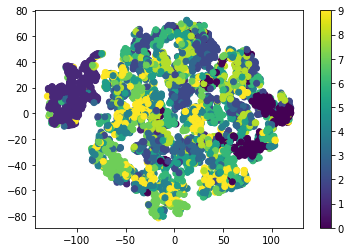

In [12]:
# 視覺化圖片特徵

from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt

# mpl.rcParams['font.sans-serif'] = ['SimHei']  # 用來標準顯示中文標簽
# mpl.rcParams['font.family'] = 'STSong'
# mpl.rcParams['font.size'] = 20

try:
    # https://www.deeplearn.me/2137.html  perplexity困惑度 n_components最終維度
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=2000)  # init='pca'表示進行PCA演算法的降維處理
    low_dim_embs = tsne.fit_transform(x_test_encoded)
except ImportError:
    print('Please install sklearn, matplotlib, and scipy to show embeddings.')

plt.scatter(low_dim_embs[:, 0], low_dim_embs[:, 1], c=y_test[:testn])
plt.colorbar()
plt.show()

## 進行圖片搜索

我們這邊的實現步驟如下:
1. 載入編碼器模型
2. 對樣本集合中的所有圖片進行編碼
3. 隨機選取一張圖片
4. 找出與該圖片最相近的20張圖片，並輸出其對應的標籤

In [14]:
# 驗證搜尋

index = random.randrange(0, len(y_test[:testn]))  # 隨機取得一個索引
mse = list(map(lambda x: ((x_test_encoded[index] - x) ** 2).sum(), x_test_encoded)) # 計算給定圖片的特徵，與其它圖片的特徵，之間的歐氏距離

# 按照距離，進行排序
user_ranking_idx = sorted(enumerate(mse), key=lambda p: p[1])  # , reverse=True

findy = [y_test[i] for i, v in user_ranking_idx]
print(y_test[index], findy[:20]) # 輸出前20張圖片所對應的標籤

8 [8, 8, 7, 8, 8, 5, 8, 8, 8, 8, 3, 8, 8, 5, 8, 8, 8, 5, 5, 8]


結果中，第一個值是給定的圖片標籤，後面其他的值，是根據圖片搜索出來的相近圖片的標籤。